In [1]:
# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
# !pip install -e ./taming-transformers
# !pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

# import sys
# sys.path.append(".")
# sys.path.append('./taming-transformers')
# from taming.models import vqgan # checking correct import from taming

In [2]:
# %cd latent-diffusion
import ipywidgets as widgets
from IPython.display import display

mode = widgets.Select(options=['superresolution'],
    value='superresolution', description='Task:')
display(mode)

Select(description='Task:', options=('superresolution',), value='superresolution')

In [3]:
import torch
print(torch.__version__)

1.13.1+cu117


In [4]:
resolution = widgets.Select(options=['64-256', '32-64'],
    value='64-256', description='SR resolutions:')
display(resolution)

Select(description='SR resolutions:', options=('64-256', '32-64'), value='64-256')

In [5]:
# Define variables

## LDM 64->256
if resolution.value == "64-256":
    print("64-256 selected")
    path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
    path_ckpt = ".\\trained_models\\epoch=000052.ckpt"
    # path_ckpt = ".\\trained_models\\epoch=000049.ckpt"
    # path_conf = "./models/ldm/ffhq256/ffhq256_sr.yaml"
    # path_ckpt = "/home/zhren/Charlie/charlie-latent-diffusion/latent-diffusion/logs/2023-01-21T17-53-30_ffhq256_sr/checkpoints/epoch=000052.ckpt"
    # path_conf = ".\\models\\ldm\\bsr_sr\\config.yaml"
    # path_ckpt = ".\\models\\ldm\\bsr_sr\\model.ckpt"

    up_f = 4
## LDM 32->64
elif resolution.value == "32-64":
    print("32-64 selected")
    path_conf = ".\\models\\trained_model_config\\ffhq32-64_sr.yaml"
    path_ckpt = ".\\trained_models\\epoch=000014.ckpt"
    up_f = 2
# path_conf = ".\\models\\ldm\\ffhq256\\ffhq256_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000052.ckpt"

# path_conf = ".\\models\\ldm\\ffhq256\\ffhq32-64_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000014.ckpt"
# uploaded_img = "" # 给一张照片

64-256 selected


In [6]:
import os
os.path.isfile(path_ckpt)
torch.cuda.is_available()
torch.cuda.empty_cache()


In [7]:
from notebook_helpers import get_local_model
model = get_local_model(path_conf, path_ckpt) # load model

Loading model from .\trained_models\epoch=000052.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys


In [8]:
# from notebook_helpers import get_custom_cond

# get_custom_cond(mode.value, uploaded_img=uploaded_img)

In [9]:
from notebook_helpers import get_cond_options, get_cond
dir, options = get_cond_options(mode.value)
cond_choice = widgets.RadioButtons(
        options=options,
        description='Select conditioning:',
        disabled=False,
        value = "face64_1.png"
    )
display(cond_choice)

RadioButtons(description='Select conditioning:', index=5, options=('face256_1.png', 'face32_1.png', 'face32_2.…

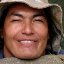

heyeheyhey
original c shape: torch.Size([1, 3, 64, 64])
heyeheyhey
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.53it/s]

Plotting: Restored training weights


In [10]:
from notebook_helpers import run
import os
custom_steps = 200
cond_choice_path = os.path.join(dir, cond_choice.value)
logs = run(model["model"], cond_choice_path, mode.value, custom_steps, up_f)

(1, 256, 256, 3)


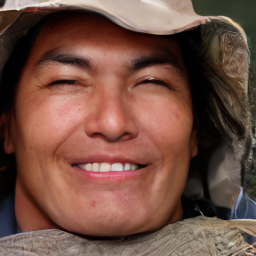

In [11]:
import torch
import numpy as np
import IPython.display as d
from PIL import Image

sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0])
display(a)
